## Veify seveal hypothesis:

1. Blacks in urban America are more likely to vote and vote for the Democratic candidates than are Blacks in rural America.
 
2. Blacks in suburban America are more likely to vote for the Republican candidates than are Blacks in urban America.
 
3. Whites in rural America are more likely to vote Republicans than are Whites in urban or suburban America.
 
4. White non-voters are more likely to live in rural American than in urban America.

we try two methods to verify:

1. classical stat hypo-test (Binomial test, Chi-square test) 

2. run logit-reg, check the learned feature importance

### update features (03/11/2024)
- ratio of intend-to-vote but finally no-voter
- per year analysis over ratio



In [1]:
import pandas as pd
import numpy as np
import utils
# import model
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import matplotlib.pyplot as plt


# data path
file_path = '../data/cumulative_2022_v3_9_domain.csv'

data = pd.read_csv(file_path)

column_to_variable_dict = np.load('../data/column_to_variable_dict.npy', allow_pickle=True).item()
variable_to_column_dict = np.load('../data/variable_to_column_dict.npy', allow_pickle=True).item()

value_label_dict = np.load('../data/value_labels.npy', allow_pickle=True).item()

# check the "Year" column's max and min value
print(data['Year'].max())
print(data['Year'].min())

2020.0
1948.0


In [5]:
target_variable = 'Voted'

'''Voted  {0.0: '0. DK; NA; no Post IW; refused to say if voted;', 1.0: '1. No, did not vote', 2.0: '2. Yes, voted'}'''

# filter out the samples with missing value of the target variable,drop the index
data_new = data[data[target_variable].notnull()]
# filter out the samples with target variable value = 0, count the number of samples whose target variable value = 0, 1 or 2

print('number of samples who not vote : ', len(data_new[data_new[target_variable] == 1]))
print('number of samples who vote : ', len(data_new[data_new[target_variable] == 2]))
print('number of samples who vote case DK : ', len(data_new[data_new[target_variable] == 0]))

sub_target_variable = 'Pre_election_inten_vote'

'''Pre_election_inten_vote  {0.0: '0. DK (1964 only); NA; no Pre IW; DK/NA/RF (1952', 1.0: '1. Democratic candidate (with or without qualifications,', 2.0: '2. Republican candidate (with or without qualifications,', 3.0: '3. Undecided; DK (except 1964)', 4.0: "4. R does not intend to vote (incl. 'no, qualified' if", 9.0: '9. Other candidate'}
'''
#  count the number of samples whose sub target variable value = 0, 1, 2, 3, 4, 9, and with missing value
print('\n\n number of samples who not intend vote : ', len(data_new[data_new[sub_target_variable] == 4]))

print('number of samples who intend vote for Democratic candidate : ', len(data_new[data_new[sub_target_variable] == 1]))

print('number of samples who intend vote for Republican candidate : ', len(data_new[data_new[sub_target_variable] == 2]))

print('number of samples who undecided : ', len(data_new[data_new[sub_target_variable] == 3]))

print('number of samples who intend vote for other candidate : ', len(data_new[data_new[sub_target_variable] == 9]))

print('number of samples who intend vote case DK : ', len(data_new[data_new[sub_target_variable] == 0]))

print('number of samples who intend vote with missing value : ', len(data_new[data_new[sub_target_variable].isnull()]))


number of samples who not vote :  17790
number of samples who vote :  44188
number of samples who vote case DK :  0


 number of samples who not intend vote :  4879
number of samples who intend vote for Democratic candidate :  16538
number of samples who intend vote for Republican candidate :  14549
number of samples who undecided :  1892
number of samples who intend vote for other candidate :  1442
number of samples who intend vote case DK :  0
number of samples who intend vote with missing value :  22678


## 1. Stat Method (hypo-test)

In [48]:


def stat_ratio(group,group_name=None, print_flag=False):

    # compute the length and the raios of voter/non-voter, vote_D, vote_R

    ratio_dict = {}

    if group_name is not None:

        ratio_dict['name']=group_name
    group_size =   len(group)
    # print(group_size)
    voter_size = len(group[group['Voted'] == 2])

    real_voter_D_R_size = len(group[group['Voted_party'] == 1.0]) + len(group[group['Voted_party'] == 2.0])

    ratio_dict['voter_ratio'] = voter_size/group_size
    ratio_dict['non_voter_ratio'] = len(group[group['Voted'] == 1])/group_size
    ratio_dict['vote_D_ratio'] = len(group[group['Voted_party'] == 1.0])/real_voter_D_R_size
    ratio_dict['vote_R_ratio'] = len(group[group['Voted_party'] == 2.0])/real_voter_D_R_size

    ratio_dict['group_size'] = group_size
    ratio_dict['voter_size'] = voter_size
    ratio_dict['non_voter_size'] =  len(group[group['Voted'] == 1])
    ratio_dict['vote_D_size'] = len(group[group['Voted_party'] == 1.0])
    ratio_dict['vote_R_size'] = len(group[group['Voted_party'] == 2.0])
    ratio_dict['real_voter_D_R_size'] = real_voter_D_R_size

    if print_flag:
        print(ratio_dict)


    return ratio_dict

def stat_ratio_by_period(group,period_list=[(1948,2020)],group_name=None):
    
    # compute the stat_ratio by cummulative years
    """problem: some group size are zero"""

    result_dict = {}
    result_dict['name']=group_name
    result_dict['total_stat'] =  stat_ratio(group,group_name)
    print(result_dict['total_stat'])

    result_dict['period_stat'] = []
    # period_list = [(1983,2011),(2012,2020)]

    for period in period_list:
        start_year = period[0]
        end_year = period[1]
        sub_group = group[(group['Year'] <= end_year) & (group['Year'] >=start_year)]
        result_dict['period_stat'].append(stat_ratio(sub_group,group_name))
    return result_dict


def urban_rural_analysis(group,group_name):
    # urban_rural_analysis
    with_urbanism_group = group[group['urbanism'].notnull()]
    no_urbanism_group = group[group['urbanism'].isnull()]

    urban_group = group[group['urbanism']==1]
    suburban_group = group[group['urbanism']==2]
    rural_group = group[group['urbanism']==3]

    result_dict = {}
    result_dict['name']=group_name+'_urban_rural'
    result_dict['tota'] =  stat_ratio(group,group_name,print_flag=True)
    result_dict['with_urbanism'] =  stat_ratio(urban_group,group_name+'_with_urbanism')
    result_dict['no_urbanism'] =  stat_ratio(no_urbanism_group,group_name+'_no_urbanism')
    result_dict['urban'] =  stat_ratio(urban_group,group_name+'_urban',print_flag=True)
    result_dict['suburban'] =  stat_ratio(suburban_group,group_name+'_suburban',print_flag=True)
    result_dict['rural'] =  stat_ratio(rural_group,group_name+'_rural',print_flag=True)

    return result_dict


In [23]:
_ = urban_rural_analysis(data_new[data_new['Race7'] == 2],group_name='black')
print('\n')
_ = urban_rural_analysis(data_new[data_new['Race7'] == 1],group_name='white')


{'name': 'black', 'voter_ratio': 0.6525862068965518, 'non_voter_ratio': 0.3474137931034483, 'vote_D_ratio': 0.9440188568061285, 'vote_R_ratio': 0.05598114319387154, 'group_size': 6960, 'voter_size': 4542, 'non_voter_size': 2418, 'vote_D_size': 3204, 'vote_R_size': 190, 'real_voter_D_R_size': 3394}
{'name': 'black_urban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747}
{'name': 'black_suburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'group_size': 829, 'voter_size': 439, 'non_voter_size': 390, 'vote_D_size': 213, 'vote_R_size': 28, 'real_voter_D_R_size': 241}
{'name': 'black_rural', 'voter_ratio': 0.43308550185873607, 'non_voter_ratio': 0.5669144981412639,

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# group =data_new[data_new['Race7'] == 1]

# with_urbanism_group = group[group['urbanism'].notnull()]

# with_urbanism_group['Year'].value_counts().sort_index().plot(kind='bar',title='white with urbanism feature')

# urban_group = group[group['urbanism']==1]
# suburban_group = group[group['urbanism']==2]
# rural_group = group[group['urbanism']==3]

period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]

# urban_group_period_dict =  stat_ratio_by_period(urban_group,period_list,group_name='white_urban')
# suburban_group_period_dict =  stat_ratio_by_period(suburban_group,period_list,group_name='white_suburban')
# rural_group_period_dict =  stat_ratio_by_period(rural_group,period_list,group_name='white_rural')

def extract_period_ratio(result_dict, ratio_name):
    result = []
    for period_dict in result_dict['period_stat']:
        result.append(period_dict[ratio_name])
    return np.array(result)

# extract_period_ratio(urban_group_period_dict, 'voter_ratio')

# plot the voter ratio by period across different urbanism

def plot_period(group, group_name='white', ratio_name='voter_ratio', period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]):

    urban_group = group[group['urbanism']==1]
    suburban_group = group[group['urbanism']==2]
    rural_group = group[group['urbanism']==3]

    # period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]

    urban_group_period_dict =  stat_ratio_by_period(urban_group ,period_list, group_name+'urban')
    suburban_group_period_dict =  stat_ratio_by_period(suburban_group,period_list,group_name+'suburban')
    rural_group_period_dict =  stat_ratio_by_period(rural_group,period_list,group_name+'rural')

    # period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]
    period_list_str = [str(item[0])+'-'+str(item[1]) for item in period_list]

    urban_voter_ratio = extract_period_ratio(urban_group_period_dict, ratio_name)
    suburban_voter_ratio = extract_period_ratio(suburban_group_period_dict,ratio_name)
    rural_voter_ratio = extract_period_ratio(rural_group_period_dict,ratio_name)


    plt.plot(period_list_str,urban_voter_ratio, label='urban', marker='o')
    plt.plot(period_list_str,suburban_voter_ratio, label='suburban', marker='*')
    plt.plot(period_list_str,rural_voter_ratio, label='rural', marker='x')
    plt.legend()

    plt.title( ratio_name +'_of_'+ group_name  + '_by period across different urbanism')
    plt.ylabel(ratio_name)
    plt.xlabel('period')


{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'group_size': 12622, 'voter_size': 8865, 'non_voter_size': 3757, 'vote_D_size': 1998, 'vote_R_size': 2883, 'real_voter_D_R_size': 4881}
{'name': 'whiterural', 'voter_ratio': 0.6569960713206406, 'non_voter_ratio': 0.3430039286793593, 'vote_D_ratio': 0.41519188705508053, 'vote_R_ratio': 0.5848081129449195, 'group_size': 13236, 'voter_size': 8696, 'non_voter_size': 4540, 'vote_D_size': 2088, 'vote_R_size': 2941, 'real_voter_D_R_size': 5029}


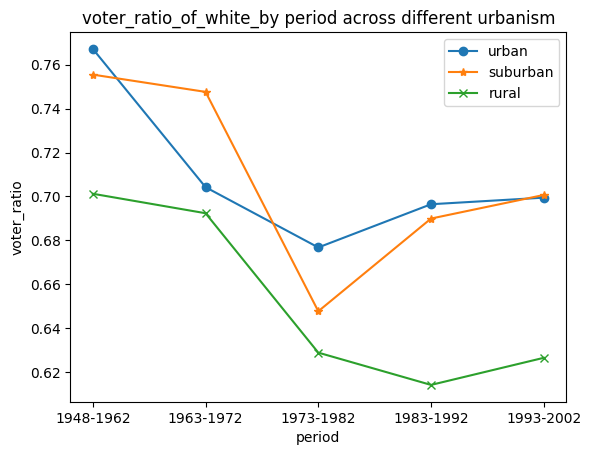

In [73]:
plot_period(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='voter_ratio', period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)])



{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'group_size': 12622, 'voter_size': 8865, 'non_voter_size': 3757, 'vote_D_size': 1998, 'vote_R_size': 2883, 'real_voter_D_R_size': 4881}
{'name': 'whiterural', 'voter_ratio': 0.6569960713206406, 'non_voter_ratio': 0.3430039286793593, 'vote_D_ratio': 0.41519188705508053, 'vote_R_ratio': 0.5848081129449195, 'group_size': 13236, 'voter_size': 8696, 'non_voter_size': 4540, 'vote_D_size': 2088, 'vote_R_size': 2941, 'real_voter_D_R_size': 5029}


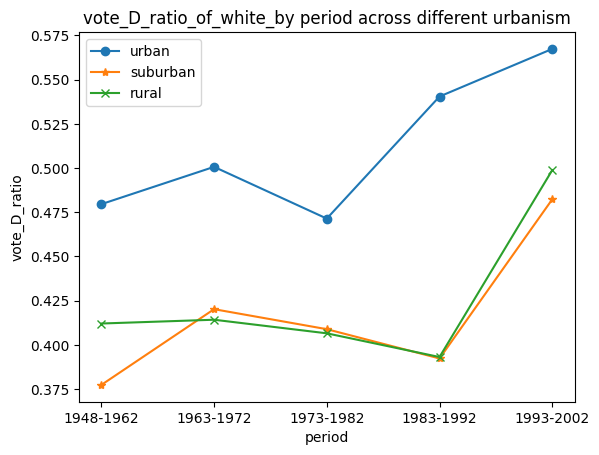

In [74]:
plot_period(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='vote_D_ratio', period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)])

{'name': 'whiteurban', 'voter_ratio': 0.7094979835905993, 'non_voter_ratio': 0.29050201640940065, 'vote_D_ratio': 0.5051405071967101, 'vote_R_ratio': 0.49485949280328995, 'group_size': 7191, 'voter_size': 5102, 'non_voter_size': 2089, 'vote_D_size': 1474, 'vote_R_size': 1444, 'real_voter_D_R_size': 2918}
{'name': 'whitesuburban', 'voter_ratio': 0.7023451117097133, 'non_voter_ratio': 0.2976548882902868, 'vote_D_ratio': 0.4093423478795329, 'vote_R_ratio': 0.5906576521204672, 'group_size': 12622, 'voter_size': 8865, 'non_voter_size': 3757, 'vote_D_size': 1998, 'vote_R_size': 2883, 'real_voter_D_R_size': 4881}
{'name': 'whiterural', 'voter_ratio': 0.6569960713206406, 'non_voter_ratio': 0.3430039286793593, 'vote_D_ratio': 0.41519188705508053, 'vote_R_ratio': 0.5848081129449195, 'group_size': 13236, 'voter_size': 8696, 'non_voter_size': 4540, 'vote_D_size': 2088, 'vote_R_size': 2941, 'real_voter_D_R_size': 5029}


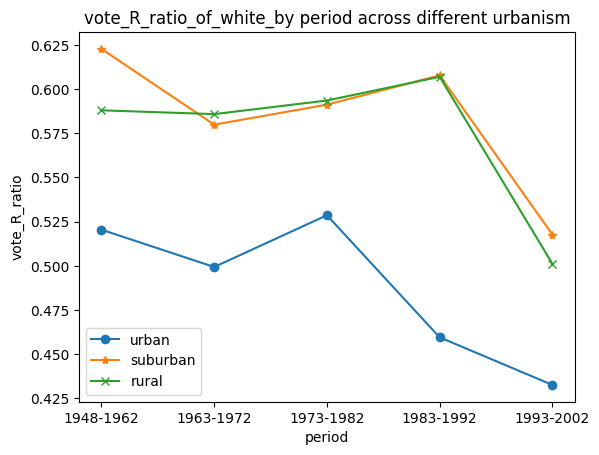

In [75]:
plot_period(data_new[data_new['Race7'] == 1], group_name='white', ratio_name='vote_R_ratio', period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)])

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'group_size': 829, 'voter_size': 439, 'non_voter_size': 390, 'vote_D_size': 213, 'vote_R_size': 28, 'real_voter_D_R_size': 241}
{'name': 'blackrural', 'voter_ratio': 0.43308550185873607, 'non_voter_ratio': 0.5669144981412639, 'vote_D_ratio': 0.8602941176470589, 'vote_R_ratio': 0.13970588235294118, 'group_size': 1076, 'voter_size': 466, 'non_voter_size': 610, 'vote_D_size': 234, 'vote_R_size': 38, 'real_voter_D_R_size': 272}


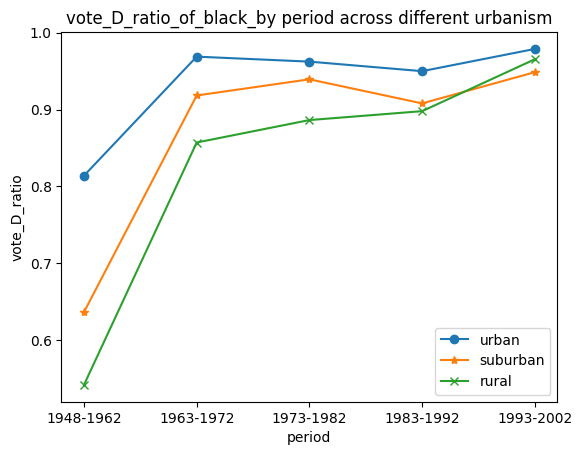

In [76]:
plot_period(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='vote_D_ratio', period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)])

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'group_size': 829, 'voter_size': 439, 'non_voter_size': 390, 'vote_D_size': 213, 'vote_R_size': 28, 'real_voter_D_R_size': 241}
{'name': 'blackrural', 'voter_ratio': 0.43308550185873607, 'non_voter_ratio': 0.5669144981412639, 'vote_D_ratio': 0.8602941176470589, 'vote_R_ratio': 0.13970588235294118, 'group_size': 1076, 'voter_size': 466, 'non_voter_size': 610, 'vote_D_size': 234, 'vote_R_size': 38, 'real_voter_D_R_size': 272}


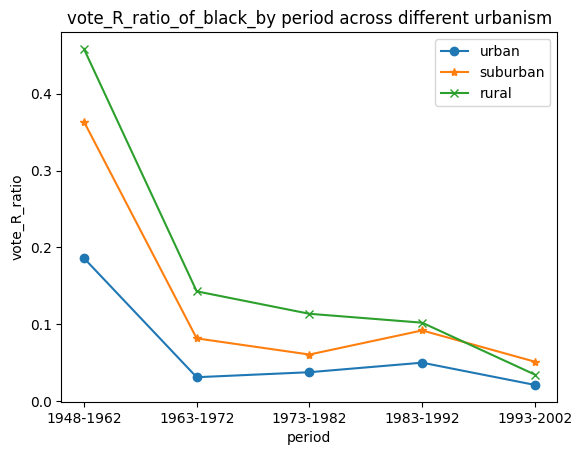

In [77]:
plot_period(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='vote_R_ratio', period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)])

{'name': 'blackurban', 'voter_ratio': 0.602628001812415, 'non_voter_ratio': 0.39737199818758495, 'vote_D_ratio': 0.9451137884872824, 'vote_R_ratio': 0.05488621151271754, 'group_size': 2207, 'voter_size': 1330, 'non_voter_size': 877, 'vote_D_size': 706, 'vote_R_size': 41, 'real_voter_D_R_size': 747}
{'name': 'blacksuburban', 'voter_ratio': 0.5295536791314838, 'non_voter_ratio': 0.4704463208685163, 'vote_D_ratio': 0.8838174273858921, 'vote_R_ratio': 0.11618257261410789, 'group_size': 829, 'voter_size': 439, 'non_voter_size': 390, 'vote_D_size': 213, 'vote_R_size': 28, 'real_voter_D_R_size': 241}
{'name': 'blackrural', 'voter_ratio': 0.43308550185873607, 'non_voter_ratio': 0.5669144981412639, 'vote_D_ratio': 0.8602941176470589, 'vote_R_ratio': 0.13970588235294118, 'group_size': 1076, 'voter_size': 466, 'non_voter_size': 610, 'vote_D_size': 234, 'vote_R_size': 38, 'real_voter_D_R_size': 272}


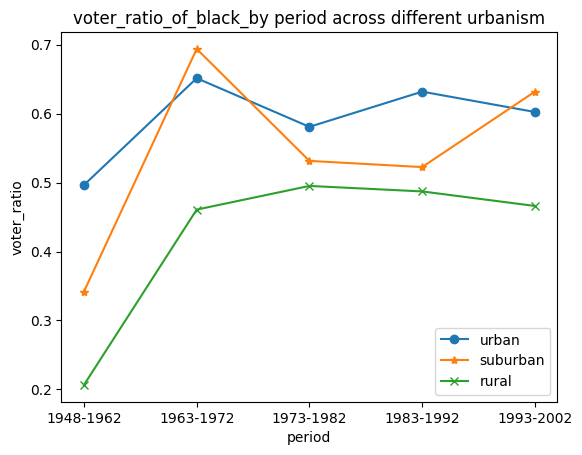

In [78]:
plot_period(data_new[data_new['Race7'] == 2], group_name='black', ratio_name='voter_ratio', period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)])

In [59]:
period_list = [(1948,1962),(1963, 1972),(1973, 1982),(1983, 1992),(1993, 2002)]
period_list_str = [str(item[0])+'-'+str(item[1]) for item in period_list]

urban_voter_ratio = extract_period_ratio(urban_group_period_dict, 'voter_ratio')
suburban_voter_ratio = extract_period_ratio(suburban_group_period_dict, 'voter_ratio')
rural_voter_ratio = extract_period_ratio(rural_group_period_dict, 'voter_ratio')


plt.plot(period_list_str,urban_voter_ratio, label='urban')
plt.plot(period_list_str,suburban_voter_ratio, label='suburban')
plt.plot(period_list_str,rural_voter_ratio, label='rural')
plt.legend()

plt.title('white voter ratio by period across different urbanism')
plt.ylabel('voter_ratio')

array([0.76717557, 0.70421649, 0.6767738 , 0.69645293, 0.69945355])

([<matplotlib.axis.XTick at 0x7f115c77f370>,
 [Text(0, 0, 'urban'), Text(1, 0, 'suburban'), Text(2, 0, 'rural')])

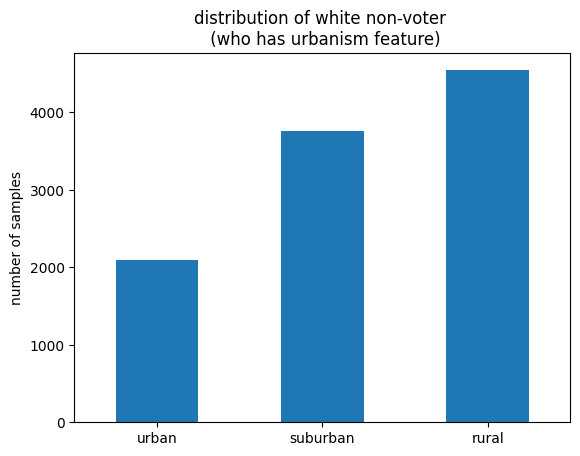

In [43]:
# no_urbanism_group['Year'].value_counts().sort_index().plot(kind='bar',title='white')

non_voter_white = group[group['Voted'] == 1]

# plot the distribution of non-voter white by urbanism
# add x-axis label: 1.0-urban, 2.0-suburban, 3.0-urban
# add y-axis label: number of samples
# add title: white non-voter

dist = non_voter_white['urbanism'].value_counts().sort_index()

import matplotlib.pyplot as plt

# add x-ticks: 1.0-urban, 2.0-suburban, 3.0-rural

dist.plot(kind='bar',title='distribution of white non-voter \n (who has urbanism feature)',ylabel='number of samples')
plt.xticks([0,1,2],['urban','suburban','rural'],rotation=0)





In [33]:
non_voter_white['urbanism'].value_counts().sort_index()

1.0    2089
2.0    3757
3.0    4540
Name: urbanism, dtype: int64

In [34]:
len(non_voter_white)

13037

### problen of black group analysis: 
1- "urbanism" seems be a old feature (only use till 2000) (check with black_with_urbanism_group.['Year'].value_counts())

2- Many voters's "vote_party" variable are missing  


In [12]:

# get the black group and subgroup of Urban, Suburban and Rural
black_group = data_new[data_new['Race7'] == 2]
black_with_urbanism_group = black_group[black_group['urbanism'].notnull()]
black_no_urbanism_group = black_group[black_group['urbanism'].isnull()]

black_urban_group = black_group[black_group['urbanism']==1]
black_suburban_group = black_group[black_group['urbanism']==2]
black_rural_group = black_group[black_group['urbanism']==3]


# black_ratio_dict =  stat_ratio_by_period(black_group, 'black_group')
# black_with_urbanism_dict =  stat_ratio_by_period(black_with_urbanism_group, 'black_with_urbanism_group')        
# black_no_urbanism_dict =  stat_ratio_by_period(black_no_urbanism_group, 'black_no_urbanism_group')        

# black_urban_ratio_dict =  stat_ratio_by_period(black_urban_group, 'black_urban_group')
# black_suburban_ratio_dict =  stat_ratio_by_period(black_suburban_group, 'black_suburban_group')
# black_rural_ratio_dict =  stat_ratio_by_period(black_rural_group, 'black_rural_group')


black_ratio_dict =  stat_ratio(black_group, 'black_group', print_flag=True)
black_with_urbanism_dict =  stat_ratio(black_with_urbanism_group, 'black_with_urbanism_group', print_flag=True)        
black_no_urbanism_dict =  stat_ratio(black_no_urbanism_group, 'black_no_urbanism_group',    print_flag=True)        

black_urban_ratio_dict =  stat_ratio(black_urban_group, 'black_urban_group', print_flag=True)
black_suburban_ratio_dict =  stat_ratio(black_suburban_group, 'black_suburban_group',   print_flag=True)
black_rural_ratio_dict =  stat_ratio(black_rural_group, 'black_rural_group',    print_flag=True)

1.0    706
2.0     41
Name: Voted_D_R, dtype: int64

In [21]:
"""Blacks in urban America are more likely to vote and vote for the Democratic candidates than are Blacks in rural America."""
def binom_test(group_dict, sub_group_dict):
    # apply the binomial test to test the difference between given groups

def chi2_test()


,Year,South,region,racial_composition_nbhood,racial_composition_gradeSchool,racial_composition_juniorHigh,racial_composition_highSchool,racial_composition_shops,racial_composition_friends,length_residence_home,...,interest_pubAffair,therm_DemParty,therm_RepParty,Voted_party,Voted_D_R,Family_income,occupation,occupation14,occupation71,home_ownership
10,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
37,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
44,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
60,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,3.0,NaN,NaN,NaN,NaN
62,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68194,2020.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0
68197,2020.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,60.0,15.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0
68201,2020.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,60.0,15.0,1.0,1.0,1.0,NaN,NaN,NaN,2.0
68210,2020.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,2.0


In [ ]:
def binom_test(group_dict, sub_group_dict):
    # apply the binomial test to test the difference between given groups

In [8]:

import numpy as np
import scipy.stats as stats

# 示例数据生成
np.random.seed(42) # 确保结果可复现

# 假设我们有两个地区的黑人选民投票数据，urban（城市）和 rural（农村）
# 假设城市有100个样本，农村有100个样本
# 假定城市中有75人投票给了民主党，农村中有60人投票给了民主党

# 投票数据模拟
urban_votes = np.random.binomial(1, 0.75, 100) # 城市，75%投给民主党
rural_votes = np.random.binomial(1, 0.60, 100) # 农村，60%投给民主党

# 二项检验 - 检验城市地区投给民主党的比例是否显著不同于0.75
binom_test_urban = stats.binom_test(urban_votes.sum(), n=100, p=0.75, alternative='two-sided')

# 卡方检验 - 比较城市和农村投票给民主党的比例差异
# 构建列联表
contingency_table = np.array([[urban_votes.sum(), 100 - urban_votes.sum()],
                              [rural_votes.sum(), 100 - rural_votes.sum()]])

chi2_test = stats.chi2_contingency(contingency_table)[:2] # 取卡方统计量和p值

binom_test_urban, chi2_test


(0.908200308233164, (5.834757834757835, 0.015712572311655546))

### ve